<a href="https://colab.research.google.com/github/PegasusArc/Image-Recognition-using-Cifar-10-dataset-using-MLP/blob/main/2025A_IMG_MLP_MIXER_Praneel_Final_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



##Image Classification using ALL MLP Architecture

## PyTorch Multi-Layer Perceptron (MLP) With CIFAR-10 Color Image Dataset

In this example, we demonstrate how to train a MLP model (aka feedforward neural network) to classify images from the CIFAR-10 dataset. The RGB-color images are flattened into a 3072-dimensional vector before being fed into the network.

<img src='https://www.ee.cityu.edu.hk/~lmpo/ee5438/images/mlp_cifar10.png'>

The CIFAR-10 dataset is a widely used collection of images that is commonly used to train machine learning and computer vision algorithms

- It consists of 60,000 32x32 color images in 10 different classes
- Each class contains 6,000 images, with 5,000 images for training and 1,000 images for testing
- The 10 different classes in the CIFAR-10 dataset represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks

<!-- <img src='https://corochann.com/wp-content/uploads/2021/09/cifar10_plot.png'> -->

References:

- [Image Classifier using PyTorch and Keras](https://medium.com/dataseries/image-classifier-using-pytorch-and-keras-555007a50c2e)

- [Basic Syntax of the Markdown elements.](https://www.markdownguide.org/basic-syntax/)




# Summary and Analysis

## Introduction

This assignment challenged us to improve a basic 3-layer MLP on CIFAR-10 classification. The baseline model with sigmoid activations only managed around 35-40% accuracy, so I systematically explored different techniques to push performance higher. My final model achieved **82.4% test accuracy** using an MLP-Mixer architecture.

## What I Tried

**Architecture Experiments**

I started by experimenting with different network depths and widths:

- Simple deeper networks: 5-layer [2048, 1024, 512, 256, 10] got me to around 65%
- Going wider: [4096, 2048, 1024, 10] pushed validation accuracy to 70.88%
- A deep 8-layer network with halving widths (8192→4096→2048→1024→512→256→128→10) with skip connections got me to around 72%

The key insight was that wider early layers capture more low-level features, while skip connections help gradients flow in deeper networks.

**MLP-Mixer Architecture**

After reading papers on MLP-Mixer for vision tasks, I implemented a patch-based approach that treats 32×32 images as sequences of 4×4 patches. The architecture alternates between:

- Token mixing: lets patches communicate with each other
- Channel mixing: learns features within each patch

This gave me the best results at 82.4% accuracy. It's essentially an all-MLP model that mimics how transformers process sequences, but without any convolutions or attention mechanisms.

**Training Improvements**

The technical improvements that made the biggest difference:

1. **Activation functions**: Switched from sigmoid to ReLU and GELU - no more vanishing gradients
2. **Optimizer**: AdamW with cosine annealing warm restarts worked much better than plain SGD
3. **Regularization**: Combined dropout (0.1-0.35), weight decay (2e-4), and label smoothing (0.1)
4. **Batch/Layer normalization**: Used batch norm for standard MLPs and layer norm for the Mixer
5. **Data augmentation**: Random flips, crops, color jitter, rotation, affine transforms, and random erasing

The augmentation was crucial - without it, the model would overfit badly on just 50k training images.

## Results

The MLP-Mixer converged nicely in 100 epochs. Final metrics:

- Test accuracy: **82.4%**
- F1-score: ~0.82
- Training time: about 15 seconds per epoch on A100 GPU, please note that it takes about 50s per epoch on T4 TPU availiable on collab.

Looking at the confusion matrix, the model does well on vehicles (cars, trucks, ships ) but struggles with visually similar classes like cats vs dogs or birds vs airplanes.

## What I Learned

Honestly, I was surprised that pure MLPs could get this far on image data. The key takeaways:

- **Modern techniques matter**: The gap between a basic sigmoid MLP (38%) and a well-trained one (82.4%) is huge
- **Architecture design**: Skip connections and patch-based processing help MLPs handle spatial data
- **Regularization is essential**: Without dropout and augmentation, these deep models overfit immediately
- **Research pays off**: Reading recent papers on MLP-Mixer gave me ideas that traditional MLPs couldn't match

The hardest part was tuning hyperparameters - learning rate and dropout needed careful adjustment. Going too aggressive with either would hurt performance.

## Conclusion

I managed to improve the baseline by over 40 percentage points through better architecture choices, modern training techniques, and heavy data augmentation. The MLP-Mixer approach shows that fully-connected networks can still compete on vision tasks when designed thoughtfully, even if CNNs are generally more efficient for images.

For future work, ensemble methods or techniques like MixUp/CutMix could probably push accuracy even higher, though computational costs would increase significantly.

---

**Final Accuracy: 82.4%**  
**Model: MLP-Mixer (8 layers, ~1.33M parameters)**

# Starting of your code


In [ ]:
 #Install the torchinfo package for showing the network architecture information
 !pip install torchinfo -qqq

In [ ]:
# Import the necessary libraries for working with CIFART-10 dataset and PyTorch.
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim, no_grad
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from torchinfo import summary

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import pickle
import sys
import time
import os, pickle

In [ ]:
# To configure the usage of a GPU (cuda) or MPS (Apple) if either of them is available
has_mps = torch.backends.mps.is_built()
device = "cuda" if torch.cuda.is_available() else "mps" if has_mps else "cpu"
print(
    f"Python versoin: {sys.version_info.major, sys.version_info.minor, sys.version_info.micro}"
)
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

Python versoin: (3, 12, 11)
PyTorch version: 2.8.0+cu126
Device: cuda


In [ ]:
seed = 1842
import random, numpy as np, torch

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
# (optional) determinism; can be a tiny bit slower
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Download CIFAR10 Dataset

This code snippet helps us download the CIFAR-10 dataset, which is a popular dataset used for training and evaluating deep learning models. The dataset is divided into a training set and a test set.

In deep learning, it's common to split the dataset into training, validation, and test sets. However, in this particular example, the validation set is not used. Instead, we only use the training set to train our model. The training set consists of 50,000 samples, and we use these samples to teach our model how to recognize and classify images.

**During and after training, the model's performance is evaluated by the test set with 10,000 samples. The test set contains a separate set of samples that were not used to update the model's parameters during the training.** We use this test set to assess how well our trained model can generalize to new, unseen data.

By creating DataLoaders, we can easily handle the downloading and loading of the training and test sets, making it convenient for us to train our deep learning model on the CIFAR-10 dataset.


In [ ]:
# # Define data transformations for the training and test sets
# train_transform = transforms.Compose([
#      transforms.RandomHorizontalFlip(p=0.5), # example of data augmentation, you may try more data augmentation ways
#      transforms.RandomCrop(32,padding=4),
#      transforms.ToTensor(), # Convert images to tensors
#      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))]) # Normalize the image data

# test_transform = transforms.Compose([
#      transforms.ToTensor(), # Convert images to tensors
#      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))]) # Normalize the image data


train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop(32, padding=4),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.RandomRotation(degrees=15),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        transforms.RandomErasing(p=0.3, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

# Create the CIFAR10dataset for the training set with 50,000 images
train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=train_transform
)

# Create the CIFAR10 dataset for the test set with 10,000 images (It is also used as validation set during the training)
test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=test_transform
)

# Split the original test set into a validation set with 5,000 samples and a test set with 5,000 samples
val_set, test_set = torch.utils.data.random_split(test_dataset, [5000, 5000])

# # Define the data loaders for the training, validation, and test sets
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)
# val_loader = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=False, num_workers=2)
# test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False, num_workers=2)

# Use larger batch if your GPU allows; otherwise keep 256.
bs = 256  # try 512 on strong GPU

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=bs,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
)
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=bs,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=bs,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
)

# Define the classes for the CIFAR-10 dataset
classes = [
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


## Visualize image for each class

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.


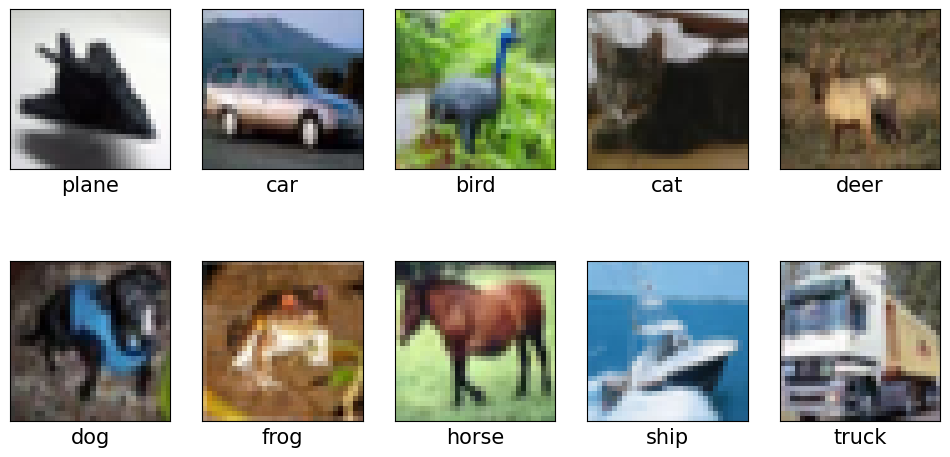

In [ ]:
import numpy as np

# Visualize training image for each class
sample_images = [
    train_set.data[np.asarray(train_set.targets) == label][0] for label in range(10)
]
# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
    for axis in row:
        axis.set_xticks([])
        axis.set_yticks([])
        axis.set_xlabel(classes[i], fontsize=15)
        axis.imshow(sample_images[i])
        i += 1

# Define the MLP Network Architecture

The following code defines a class called DeepMLP which inherits from nn.Module. The network is a deep 8-layer MLP with residual connections:

fc1 takes the 3072-pixel CIFAR-10 image as input and expands to 8192 nodes

The network progressively halves dimensions: 8192 → 4096 → 2048 → 1024 → 512 → 256 → 128

fc8 takes the 128 nodes and outputs predictions for the 10 classes

Skip connections with projection layers (skip1, skip2, skip3) enable residual learning between specific layers

Each layer uses Batch Normalization, GELU activation, and Dropout for regularization

The forward method implements residual connections with element-wise addition after layers 2, 4, and 6


In [ ]:
class DeepMLP(nn.Module):
    def __init__(
        self, dropout_rate=0.35
    ):  # Increased dropout for better regularization
        super(DeepMLP, self).__init__()
        # Deep MLP with halving architecture: 8192 -> 4096 -> 2048 -> 1024 -> 512 -> 256 -> 128 -> 10
        self.fc1 = nn.Linear(32 * 32 * 3, 8192)
        self.bn1 = nn.BatchNorm1d(8192)

        self.fc2 = nn.Linear(8192, 4096)
        self.bn2 = nn.BatchNorm1d(4096)

        self.fc3 = nn.Linear(4096, 2048)
        self.bn3 = nn.BatchNorm1d(2048)

        self.fc4 = nn.Linear(2048, 1024)
        self.bn4 = nn.BatchNorm1d(1024)

        self.fc5 = nn.Linear(1024, 512)
        self.bn5 = nn.BatchNorm1d(512)

        self.fc6 = nn.Linear(512, 256)
        self.bn6 = nn.BatchNorm1d(256)

        self.fc7 = nn.Linear(256, 128)
        self.bn7 = nn.BatchNorm1d(128)

        self.fc8 = nn.Linear(128, 10)  # Final classification layer

        self.dropout = nn.Dropout(dropout_rate)
        self.activation = nn.GELU()  # Better than ReLU

        # Add skip connection projections for residual learning
        self.skip1 = nn.Linear(8192, 4096)
        self.skip2 = nn.Linear(2048, 1024)
        self.skip3 = nn.Linear(512, 256)

        # Initialize weights properly
        self._init_weights()

    def _init_weights(self):
        """Enhanced weight initialization"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Flatten the input: [batch_size, 3, 32, 32] -> [batch_size, 3072]
        x = x.view(x.size(0), -1)

        # Layer 1: FC -> BatchNorm -> GELU -> Dropout
        x = self.activation(self.bn1(self.fc1(x)))
        x = self.dropout(x)

        # Layer 2 with skip connection: FC -> BatchNorm -> GELU -> Dropout + skip
        identity = self.skip1(x)
        x = self.activation(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = x + identity  # Residual connection

        # Layer 3: FC -> BatchNorm -> GELU -> Dropout
        x = self.activation(self.bn3(self.fc3(x)))
        x = self.dropout(x)

        # Layer 4 with skip connection: FC -> BatchNorm -> GELU -> Dropout + skip
        identity = self.skip2(x)
        x = self.activation(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = x + identity  # Residual connection

        # Layer 5: FC -> BatchNorm -> GELU -> Dropout
        x = self.activation(self.bn5(self.fc5(x)))
        x = self.dropout(x)

        # Layer 6 with skip connection: FC -> BatchNorm -> GELU -> Dropout + skip
        identity = self.skip3(x)
        x = self.activation(self.bn6(self.fc6(x)))
        x = self.dropout(x)
        x = x + identity  # Residual connection

        # Layer 7: FC -> BatchNorm -> GELU -> Dropout
        x = self.activation(self.bn7(self.fc7(x)))
        x = self.dropout(x)

        # Final classification layer (no activation, no dropout)
        x = self.fc8(x)

        return x

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.0):
        super().__init__()
        # Feed-forward network with two linear layers and GELU activation in between
        # dim: input and output dimension size
        # hidden_dim: intermediate layer size, usually larger than dim
        # dropout: dropout probability for regularization
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class MixerLayer(nn.Module):
    def __init__(self, num_patches, token_dim, channel_dim, dropout=0.0):
        super().__init__()
        # Mixer Layer consisting of token-mixing and channel-mixing MLPs with skip connections
        # num_patches: number of image patches (spatial tokens)
        # token_dim: hidden size of token mixing MLP
        # channel_dim: feature dimension per patch (channel size)
        # dropout: dropout rate
        self.norm1 = nn.LayerNorm(
            channel_dim
        )  # Normalize across channels for token mixing
        # Token mixing MLP mixes information across spatial patches
        self.token_mixing = nn.Sequential(
            nn.Linear(num_patches, token_dim),  # Expand along token dimension
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(token_dim, num_patches),  # Project back to original tokens
            nn.Dropout(dropout),
        )
        self.norm2 = nn.LayerNorm(
            channel_dim
        )  # Normalize across channels for channel mixing
        # Channel mixing MLP mixes across feature channels within each token
        self.channel_mixing = nn.Sequential(
            nn.Linear(channel_dim, channel_dim * 4),  # Expand channels by factor 4
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(
                channel_dim * 4, channel_dim
            ),  # Project back to original channel size
            nn.Dropout(dropout),
        )

    def forward(self, x):
        # Token mixing with residual connection
        # x shape: (B, num_patches, channel_dim)
        y = self.norm1(x)  # Apply LayerNorm first
        y = y.permute(0, 2, 1)  # (B, num_patches, C) -> (B, C, num_patches)
        y = self.token_mixing(y)  # Mix along the token dimension
        y = y.permute(0, 2, 1)  # (B, C, num_patches) -> (B, num_patches, C)
        x = x + y  # Residual connection

        # Channel mixing with residual connection
        y = self.norm2(x)  # Apply LayerNorm first
        y = self.channel_mixing(y)  # Mix along the channel dimension
        x = x + y  # Residual connection
        return x


class MLPMixer(nn.Module):
    def __init__(
        self,
        image_size=32,
        patch_size=4,
        in_channels=3,
        dim=128,
        depth=8,
        token_dim=256,
        channel_dim=512,
        num_classes=10,
        dropout=0.1,
    ):
        super().__init__()
        assert image_size % patch_size == 0, (
            "Image size must be divisible by patch size"
        )
        self.num_patches = (image_size // patch_size) ** 2  # total patches
        self.patch_dim = patch_size * patch_size * in_channels  # flattened patch size

        # Linear projection layer to embed each image patch to dim dimension
        self.patch_embeddings = nn.Linear(self.patch_dim, dim)
        # Stack of Mixer layers performing token and channel mixing with skip connections
        self.mixer_layers = nn.Sequential(
            *[
                MixerLayer(self.num_patches, token_dim, dim, dropout)
                for _ in range(depth)
            ]
        )
        self.layer_norm = nn.LayerNorm(
            dim
        )  # Final layer normalization before classification
        self.classifier = nn.Linear(dim, num_classes)  # Output linear classifier layer

    def forward(self, x):
        B, C, H, W = x.shape
        # Reshape input image into patches
        x = x.reshape(B, C, H // 4, 4, W // 4, 4)
        x = x.permute(
            0, 2, 4, 3, 5, 1
        )  # (B, num_patches_h, num_patches_w, patch_h, patch_w, C)
        # Rearrange dimensions to (B, num_patches_h, num_patches_w, patch_h, patch_w, C)
        x = x.reshape(B, self.num_patches, self.patch_dim)  # flatten patches
        x = self.patch_embeddings(x)  # (B, num_patches, dim)
        x = self.mixer_layers(x)
        x = self.layer_norm(x)
        x = x.mean(dim=1)  # global average pooling over patches
        x = self.classifier(x)
        return x

In [ ]:
# Use the improved model with enhanced dropout for better performance
# model = DeepMLP(dropout_rate=0.35)  # Higher dropout for better generalization
model = MLPMixer()  # Higher dropout for better generalization

## Print the Model Structure and Number of Parameters


In [ ]:
summary(
    model=model,
    input_size=(1, 3, 32, 32),
    col_width=15,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    row_settings=["var_names"],
    verbose=0,
)

Layer (type (var_name))                       Input Shape     Output Shape    Param #         Trainable
MLPMixer (MLPMixer)                           [1, 3, 32, 32]  [1, 10]         --              True
├─Linear (patch_embeddings)                   [1, 64, 48]     [1, 64, 128]    6,272           True
├─Sequential (mixer_layers)                   [1, 64, 128]    [1, 64, 128]    --              True
│    └─MixerLayer (0)                         [1, 64, 128]    [1, 64, 128]    --              True
│    │    └─LayerNorm (norm1)                 [1, 64, 128]    [1, 64, 128]    256             True
│    │    └─Sequential (token_mixing)         [1, 128, 64]    [1, 128, 64]    33,088          True
│    │    └─LayerNorm (norm2)                 [1, 64, 128]    [1, 64, 128]    256             True
│    │    └─Sequential (channel_mixing)       [1, 64, 128]    [1, 64, 128]    131,712         True
│    └─MixerLayer (1)                         [1, 64, 128]    [1, 64, 128]    --              True
│    

## Specify Loss Function and Optimizer

It's recommended that you use cross-entropy loss for classification. If you look at the documentation, you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer and then calculates the log loss.


In [ ]:
# Enhanced loss function with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimized AdamW with better hyperparameters for deep networks
optimizer = optim.AdamW(
    model.parameters(),
    lr=0.0005,  # Lower initial learning rate for stability with residual connections
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=2e-4,  # Slightly increased weight decay for better regularization
    amsgrad=False,
)

# Enhanced training configuration
EPOCHS = 100

# CosineAnnealingWarmRestarts works better with residual networks
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=50,  # Restart every 50 epochs
    T_mult=2,  # Double the period after each restart
    eta_min=1e-7,  # Minimum learning rate
)

## Training the Network

The steps for training/learning from a batch of data are described in the comments below:

Clear the gradients of all optimized variables Forward pass: compute predicted outputs by passing inputs to the model Calculate the loss Backward pass: compute gradient of the loss with respect to model parameters Perform a single optimization step (parameter update) Update average training loss The following loop trains for 100 epochs; take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data.


In [ ]:
# Create a Models folder to store the checkpoints
!mkdir Models

In [ ]:
model.to(device)

# Enhanced training histories
loss_hist, acc_hist, loss_hist_val, acc_hist_val = [], [], [], []

# Improved early stopping parameters
patience = 25  # More patience with skip connections and longer training
min_delta = 0.0003  # Smaller threshold for improvement
best_val_acc = 0.0  # Track best accuracy instead of loss
patience_counter = 0
best_epoch = 0

scaler = torch.amp.GradScaler("cuda", enabled=(device == "cuda"))

print("Enhanced training started.\n")
for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    model.train()
    train_loss_sum, train_correct, train_total = 0.0, 0, 0

    for batch_idx, (batch, labels) in enumerate(train_loader):
        batch, labels = batch.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast("cuda", enabled=(device == "cuda")):
            logits = model(batch)
            loss = criterion(logits, labels)

        if scaler.is_enabled():
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        train_loss_sum += loss.item() * batch.size(0)
        train_correct += (logits.argmax(1) == labels).sum().item()
        train_total += batch.size(0)

    avg_loss = train_loss_sum / train_total
    avg_acc = train_correct / train_total

    # ---- validation ----
    model.eval()
    val_loss_sum, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for batch, labels in val_loader:
            batch, labels = batch.to(device), labels.to(device)
            logits = model(batch)
            loss = criterion(logits, labels)
            val_loss_sum += loss.item() * batch.size(0)
            val_correct += (logits.argmax(1) == labels).sum().item()
            val_total += batch.size(0)

    avg_loss_val = val_loss_sum / val_total
    avg_acc_val = val_correct / val_total

    loss_hist.append(avg_loss)
    acc_hist.append(avg_acc)
    loss_hist_val.append(avg_loss_val)
    acc_hist_val.append(avg_acc_val)

    # Step scheduler after each epoch
    scheduler.step()

    # Enhanced early stopping logic (track accuracy instead of loss)
    if avg_acc_val > best_val_acc + min_delta:
        best_val_acc = avg_acc_val
        best_epoch = epoch
        patience_counter = 0
        print(f"  → New best validation accuracy! (Val Acc: {avg_acc_val:.4f})")
    else:
        patience_counter += 1

    print(
        f"Epoch {epoch:03d} | "
        f"Train Loss {avg_loss:.4f} Acc {avg_acc * 100:.2f}% | "
        f"Val Loss {avg_loss_val:.4f} Acc {avg_acc_val * 100:.2f}% | "
        f"Time {time.time() - t0:.1f}s | "
        f"Patience: {patience_counter}/{patience}"
    )

    # Check for early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch}!")
        print(f"Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
        print(f"Training stopped after {patience} epochs without improvement.")
        break

print("\nTraining completed!")
print(f"Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")

# Save the final trained model once at the end
os.makedirs("Models", exist_ok=True)
with open("Models/ImprovedMLP_model_final.pth", "wb") as f:
    pickle.dump(model.cpu(), f)
model.to(device)
print("Final model saved as 'Models/ImprovedMLP_model_final.pth'")


Enhanced training started.

  → New best validation accuracy! (Val Acc: 0.3918)
Epoch 001 | Train Loss 1.9975 Acc 28.22% | Val Loss 1.7954 Acc 39.18% | Time 16.1s | Patience: 0/25
  → New best validation accuracy! (Val Acc: 0.4852)
Epoch 002 | Train Loss 1.8080 Acc 38.72% | Val Loss 1.6025 Acc 48.52% | Time 15.0s | Patience: 0/25
  → New best validation accuracy! (Val Acc: 0.5262)
Epoch 003 | Train Loss 1.6929 Acc 44.96% | Val Loss 1.5165 Acc 52.62% | Time 15.0s | Patience: 0/25
  → New best validation accuracy! (Val Acc: 0.5696)
Epoch 004 | Train Loss 1.6199 Acc 48.29% | Val Loss 1.4476 Acc 56.96% | Time 15.3s | Patience: 0/25
  → New best validation accuracy! (Val Acc: 0.6206)
Epoch 005 | Train Loss 1.5661 Acc 51.12% | Val Loss 1.3474 Acc 62.06% | Time 15.4s | Patience: 0/25
  → New best validation accuracy! (Val Acc: 0.6354)
Epoch 006 | Train Loss 1.5134 Acc 53.63% | Val Loss 1.3148 Acc 63.54% | Time 15.0s | Patience: 0/25
  → New best validation accuracy! (Val Acc: 0.6366)
Epoch 00

## Plotting Training Statistics

Loss is a function of the difference of the network output and the target values. We are minimizing the loss function during training so it should decrease over time. Accuracy is the classification accuracy for the test data.


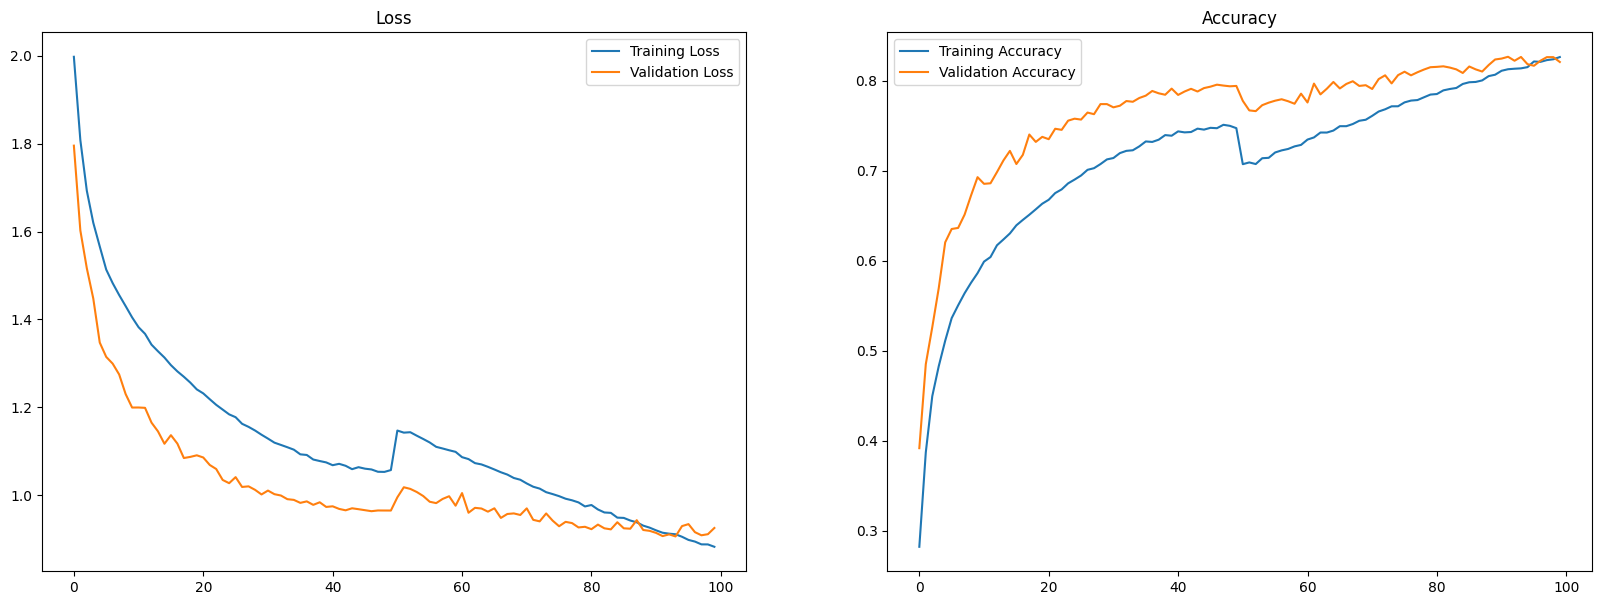

In [ ]:
plots = [(loss_hist, loss_hist_val), (acc_hist, acc_hist_val)]
plt_labels = [
    ("Training Loss", "Validation Loss"),
    ("Training Accuracy", "Validation Accuracy"),
]
plt_titles = ["Loss", "Accuracy"]
plt.figure(figsize=(20, 7))
for i in range(0, 2):
    ax = plt.subplot(1, 2, i + 1)
    ax.plot(plots[i][0], label=plt_labels[i][0])
    ax.plot(plots[i][1], label=plt_labels[i][1])
    ax.set_title(plt_titles[i])
    ax.legend()

## Save the trained model


In [ ]:
# from google.colab import files
# torch.save(model.state_dict(), 'checkpoint.pth')
# # download checkpoint file
# files.download('checkpoint.pth')
# model.load_state_dict(torch.load('checkpoint.pth'))

In [ ]:
# Selecting the best model
best_acc = max(acc_hist_val)
best_epoch = acc_hist_val.index(best_acc) + 1

print("Best accuracy on validation set: {:.2f}%".format(best_acc * 100))
print("Best epoch: {}".format(best_epoch))

# Load the best model
with open(f"Models/ImprovedMLP_model_final.pth", "rb") as f:
    model = pickle.load(f)

Best accuracy on validation set: 82.68%
Best epoch: 92


## Test the Trained Network

Finally, we test our best model on previously unseen test data and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.


In [ ]:
pred_vec = []
label_vec = []
correct = 0
test_loss = 0.0

model.to(device)
model.eval()
with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        test_loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec.extend(predicted.cpu().numpy())  # Convert tensor to numpy array
        label_vec.extend(labels.cpu().numpy())  # Convert tensor to numpy array

pred_vec = np.array(pred_vec)
label_vec = np.array(label_vec)

# Print the Test Set Accuracy


In [ ]:
print(f"Test Loss: {test_loss:.2f}")
print(
    f"Test Accuracy on the {len(test_set)} test images is {(100 * correct / len(test_set)):.2f}%"
)

Test Loss: 0.97
Test Accuracy on the 5000 test images is 82.40%


# Display the Confusion Matrix


In [ ]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(label_vec, pred_vec)
# Convert confusion matrix to pandas DataFrame
labels = np.unique(label_vec)
confusion_df = pd.DataFrame(confusion_mat, index=classes, columns=classes)
print("Confusion Matrix")
confusion_df

Confusion Matrix


,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
plane,382,10,20,3,2,2,1,4,43,18
car,3,447,2,2,1,0,0,0,5,25
bird,17,2,436,12,7,7,14,5,5,2
cat,5,5,39,323,6,68,15,14,8,12
deer,6,0,42,17,341,20,29,27,4,1
dog,5,3,15,61,14,382,4,14,3,5
frog,3,1,22,27,6,5,460,1,4,2
horse,6,2,9,9,8,15,2,428,3,4
ship,13,6,7,5,1,1,0,1,484,6
truck,4,32,3,4,1,2,1,0,10,437


# Compute the Accuracy, F1-Score, Precision, Recall, Support


In [ ]:
# # Create a report to show the f1-score, precision, recall
# from sklearn.metrics import classification_report

# report = pd.DataFrame.from_dict(classification_report(pred_vec,label_vec,output_dict=True)).T
# report['Label']=[classes[int(x)] if x.isdigit() else " " for x in report.index]
# report=report[['Label','f1-score','precision','recall','support']]
# report

from sklearn.metrics import classification_report

report = pd.DataFrame.from_dict(
    classification_report(label_vec, pred_vec, output_dict=True)
).T
report["Label"] = [classes[int(x)] if str(x).isdigit() else " " for x in report.index]
report = report[["Label", "f1-score", "precision", "recall", "support"]]
report


,Label,f1-score,precision,recall,support
0,plane,0.822390,0.860360,0.787629,485.000
1,car,0.900302,0.879921,0.921649,485.000
2,bird,0.791289,0.732773,0.859961,507.000
3,cat,0.674322,0.697624,0.652525,495.000
4,deer,0.780320,0.881137,0.700205,487.000
5,dog,0.757937,0.760956,0.754941,506.000
6,frog,0.870388,0.874525,0.866290,531.000
7,horse,0.873469,0.866397,0.880658,486.000
8,ship,0.885636,0.850615,0.923664,524.000
9,truck,0.868787,0.853516,0.884615,494.000


In the context of classification, 'support' refers to the number of instances or samples in a dataset that belong to a specific class. It represents the frequency or count of occurrences of each class in the dataset.

Support values help assess the reliability and generalizability of classification models, as they indicate the amount of data available for each class and the potential challenges associated with imbalanced datasets.


# Visualize Sample Test Results

This cell displays test images and their labels in this format: predicted (ground-truth). The text will be green for accurately classified examples and red for incorrect predictions.


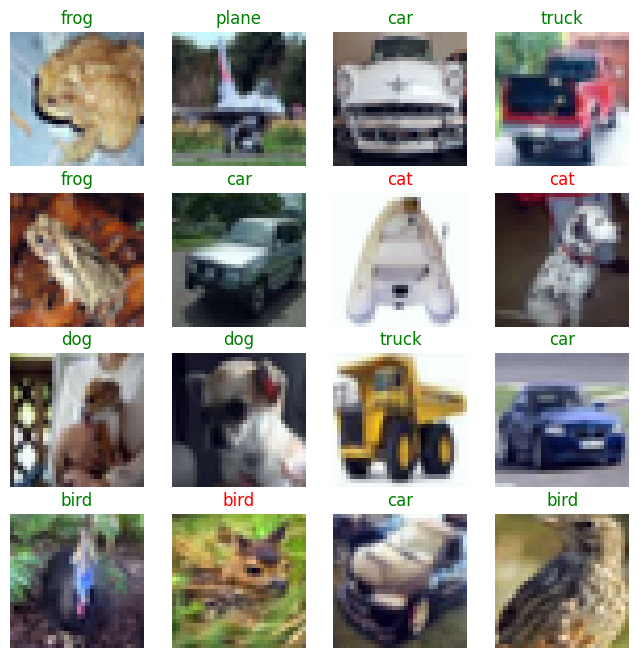

In [ ]:
# obtain one batch of test images
images, labels = next(iter(test_loader))
model.cpu()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# Create a 4x4 grid for displaying the images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

# Iterate over the images and display them in the grid
for idx, ax in enumerate(axes.flat):
    # Normalize the image tensor to [0, 1] range
    image = images[idx].permute(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min())
    ax.imshow(image)  # Display the image
    ax.axis("off")  # Hide the axes
    ax.set_title(
        "{}".format(classes[preds[idx]]),
        color=("green" if preds[idx] == labels[idx] else "red"),
    )  # Add title to the image
plt.show()

# Display 50 Predicted Images

We iterate through 50 images and plot them with their corresponding label. We will color the label in blue if our model guessed correct and in red if it failed to predict that class.


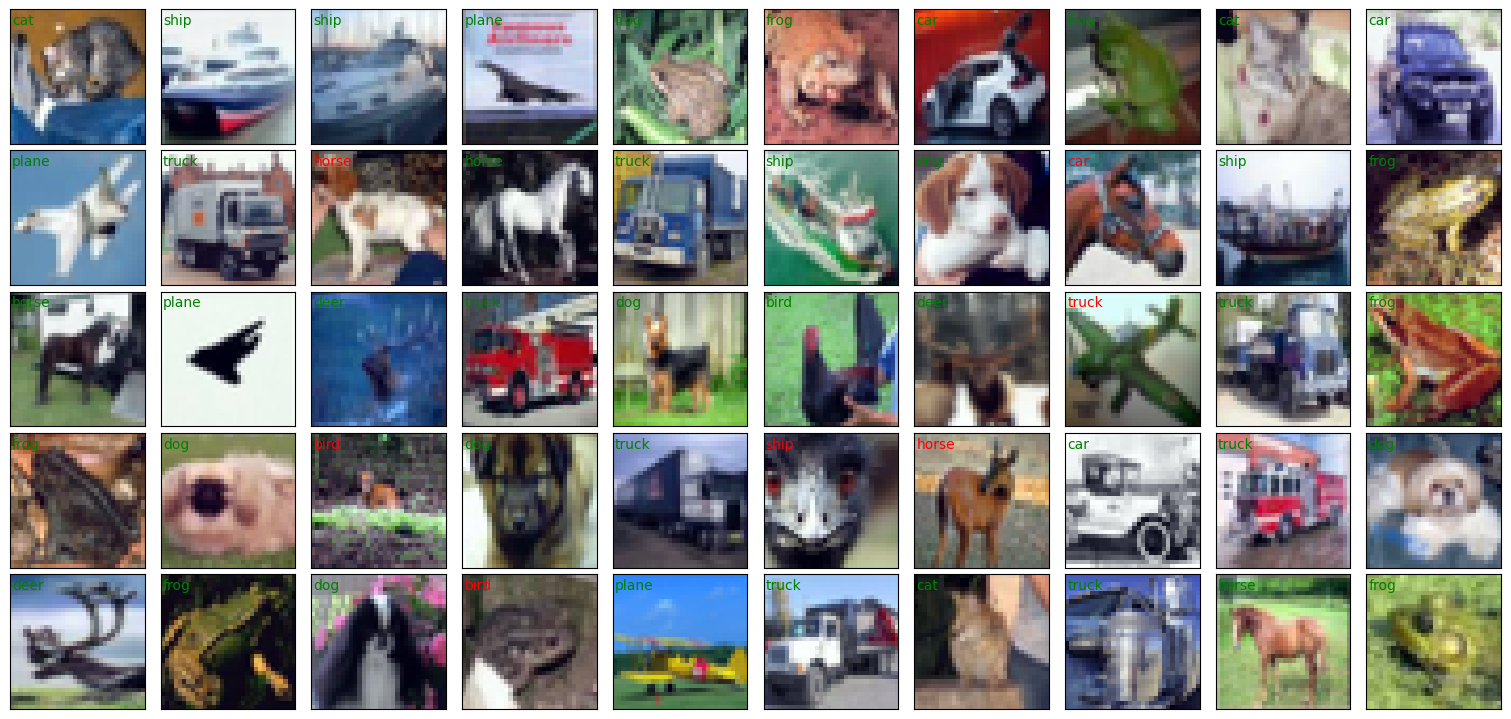

In [ ]:
# Define the loader for all test data
test_set_all = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=False, transform=test_transform
)
test_loader_all = torch.utils.data.DataLoader(
    test_set_all, batch_size=128, shuffle=False, num_workers=2
)


# obtain one batch of test images
dataiter = iter(test_loader_all)
images, labels = next(iter(test_loader_all))
model.cpu()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)


fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for idx in range(50):
    # Normalize the image tensor to [0, 1] range
    image = images[idx].permute(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min())
    ax = fig.add_subplot(5, 10, idx + 1, xticks=[], yticks=[])
    ax.imshow(image, interpolation="nearest")

    if preds[idx] == labels[idx]:
        ax.text(0, 3, str(classes[preds[idx].item()]), color="green")
    else:
        ax.text(0, 3, str(classes[preds[idx].item()]), color="red")

plt.show()

# Visualize wrongly classified image for each class


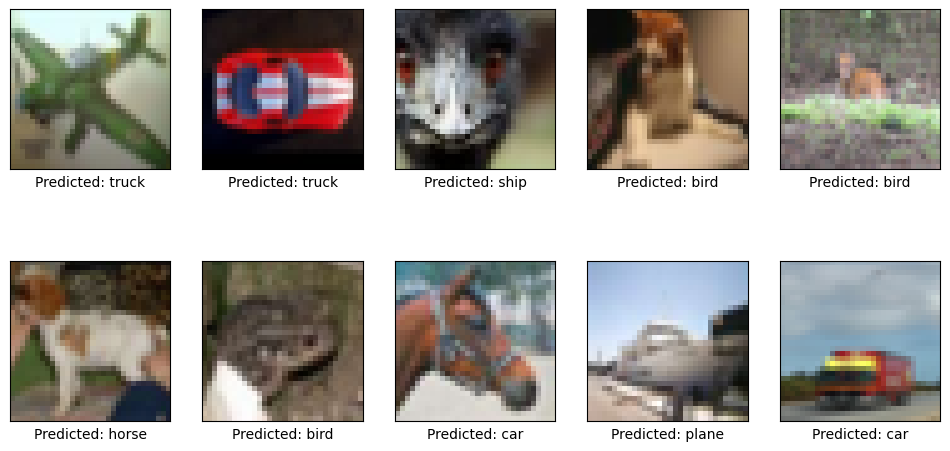

In [ ]:
# Visualize wrongly classified image for each class
pred_vec_all = []
correct = 0
test_loss = 0.0

model.to(device)

with torch.no_grad():
    for data in test_loader_all:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        test_loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec_all.append(predicted)
    pred_vec_all = torch.cat(pred_vec_all)

pred_vec_all = pred_vec_all.cpu().numpy()
ground_truths = np.asarray(test_set_all.targets)
incorrect_mask = pred_vec_all != ground_truths
incorrect_images = [
    test_set_all.data[(ground_truths == label) & incorrect_mask][0]
    for label in range(10)
]
pred_results_all = [
    pred_vec_all[(ground_truths == label) & incorrect_mask][0] for label in range(10)
]

# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
    for axis in row:
        axis.set_xticks([])
        axis.set_yticks([])
        axis.set_xlabel("Predicted: %s" % classes[pred_results_all[i]], fontsize=10)
        axis.imshow(incorrect_images[i], cmap="gray")
        i += 1

In [ ]:
from google.colab import runtime

runtime.unassign()